In [294]:
import pandas
pandas.set_option("display.max_rows", 50, "display.max_columns", 50)

import pygsheets
import numpy
import scipy

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

In [295]:
# solarized colors
solar_base03    = '#002b36' # darkest gray
solar_base02    = '#073642'
solar_base01    = '#586e75'
solar_base00    = '#657b83'
solar_base0     = '#839496' # light gray
solar_base1     = '#93a1a1' # lightest gray
solar_base2     = '#eee8d5' # dark white
solar_base3     = '#fdf6e3' # light white
solar_yellow    = '#b58900'
solar_orange    = '#cb4b16'
solar_red       = '#dc322f'
solar_magenta   = '#d33682'
solar_violet    = '#6c71c4'
solar_blue      = '#268bd2'
solar_cyan      = '#2aa198'
solar_green     = '#859900'

In [296]:
# GEM tracker colors
# done using this: https://imagecolorpicker.com/
tracker_construction = tracker_red     = '#cb4b16'
tracker_proposed = tracker_yellow  = '#ffb342'
tracker_shelved = tracker_blue    = '#609ed0'
tracker_operating = tracker_brown   = '#976f5d'
tracker_cancelled = tracker_green   = '#93db92'
tracker_mothballed = tracker_gray = '#515151'

# import data

In [388]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(client_secret=credentials_directory+'client_secret.json')
#spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')
spreadsheet = gc.open_by_key('178YQvZ8EC17LYA8sIgsOEi5veROivWi_uUnPb6tOuzE')

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet[1].get_as_df(encoding='latin1')
oil_pipes = spreadsheet[2].get_as_df(encoding='latin1')
#owners = spreadsheet[2].get_as_df()

gas_pipes = gas_pipes.drop('WKTFormat', axis=1) # delete WKTFormat column
oil_pipes = oil_pipes.drop('WKTFormat', axis=1)

# delete columns that aren't the same in the sheets, to concatenate them...
columns_not_in_oil = list(set(gas_pipes.columns)-set(oil_pipes.columns))
columns_not_in_gas = list(set(oil_pipes.columns)-set(gas_pipes.columns))
gas_pipes.drop(columns=columns_not_in_oil, axis=1, inplace=True)
oil_pipes.drop(columns=columns_not_in_gas, axis=1, inplace=True)

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)
#pipes_df_orig = pipes_df_orig[pipes_df_orig['Status']!='N/A'] # for container rows
#pipes_df_orig = pipes_df_orig[pipes_df_orig['ProjectID']!=''] # for empty rows at bottom

#get other relevant sheets
country_ratios_df = spreadsheet[5].get_as_df(encoding='latin1')
owners_df = spreadsheet[3].get_as_df(encoding='latin1')
owners_df.set_index('ProjectID', inplace=True)

In [299]:
pipes_df_orig.columns

Index(['PipelineNetworkContainer', 'PipelineName', 'SegmentName', 'Wiki',
       'ProjectID', 'Fuel', 'Countries', 'Researcher', 'LastUpdated', 'Status',
       'Parent', 'ProposalYear', 'ConstructionYear', 'StartYear1',
       'StartYear2', 'StartYear3', 'Delayed', 'DelayType', 'StartYearEarliest',
       'ShelvedYear', 'CancelledYear', 'StopYear', 'ShelvedCancelledType',
       'Capacity', 'CapacityUnits', 'CapacityBcm/y', 'CapacityBOEd',
       'LengthKnown', 'LengthKnownUnits', 'LengthKnownKm', 'LengthEstimateKm',
       'LengthMergedKm', 'Diameter', 'DiameterUnits', 'Source',
       'StartLocation', 'StartPrefecture/District', 'StartState/Province',
       'StartCountry', 'StartRegion', 'EndLocation', 'EndPrefecture/District',
       'EndState/Province', 'EndCountry', 'EndRegion', 'NumberOfCountries',
       'CostOld', 'CostOldUnits', 'CostOldUSD', 'CostEst', 'CostEstUnits',
       'CostEstYear', 'CostEstUSD', 'CostActual', 'CostActualUnits',
       'CostActualYear', 'CostActualUS

In [300]:
# set Routes b and c pipeline length equal to zero so that they're not counted toward the total
routes_to_zero_out = [
    'Route 4b Gas Pipeline',
    'Route 5b Gas Pipeline',
    'Route 5c Gas Pipeline',
    'Route 6b Gas Pipeline' ]

#routes_to_zero_out = []

cols_to_zero_out = ['LengthMergedKm']
pipes_df_orig.loc[pipes_df_orig['PipelineName'].isin(routes_to_zero_out), cols_to_zero_out] = numpy.nan

cols_to_zero_out = ['MergedKmByCountry']
country_ratios_df.loc[country_ratios_df['PipelineName'].isin(routes_to_zero_out), cols_to_zero_out] = numpy.nan

## replace "--" with NaN, removing empty rows

In [395]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']

In [302]:
pipes_df_orig[pipes_df_orig['Fuel']=='Gas']['LengthMergedKm'].sum()

1253487.5799999998

In [303]:
country_ratios_df['StartYearLatest'].replace('--', numpy.nan, inplace=True)
country_ratios_df['LengthKnownKm'].replace('--', numpy.nan, inplace=True)
country_ratios_df['CostMergedUSD'].replace('--', numpy.nan, inplace=True)
country_ratios_df['CostMergedUSDPerKm'].replace('--', numpy.nan, inplace=True)
country_ratios_df['LengthKnownKmByCountry'].replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [304]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [305]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [306]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [307]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

## add Total row to km by country/region

# numbers of pipes finished in a given year

In [308]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Gas')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [309]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Gas')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [313]:
# indev pipelines = Proposed or Construction
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev[pipes_indev['Fuel']=='Gas']
pipes_indev = pipes_indev.groupby('Status')['LengthMergedKm'].sum()

In [314]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030[(pipes_indev_to2030['Fuel']=='Gas') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()

In [315]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Gas')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'])['LengthMergedKm'].sum()

## 2016 onward plots

## 2016 onwards with 2022, 2023 labeled

## Ted's preference for 2016 onwards (lump 2022 into other stuff?)

## james' preference (same y-axis)

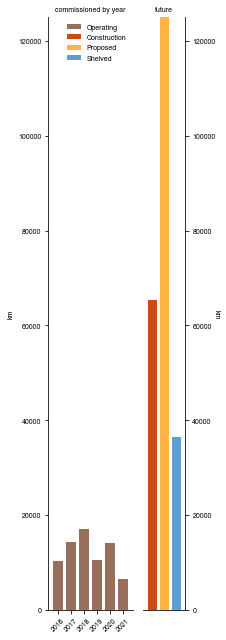

In [316]:
font_size = 7

ytop = 125000
ytop2 = 125000

fig = mp.figure(figsize=(3.25,9))

widths=[6,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-7:-1], pipes_started_sum.values[-7:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-without-2022.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-without-2022.pdf', bbox_inches='tight', transparent=True)

## Fig 2 again - 2023–2030, go back to 2008

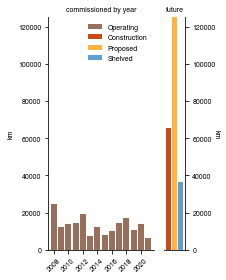

In [317]:
font_size = 7

ytop = 125000
ytop2 = 125000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev[s],
             color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-backto2008.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-backto2008.pdf', bbox_inches='tight', transparent=True)

## plus/minus 8 years

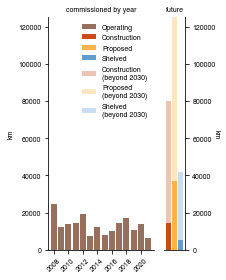

In [318]:
font_size = 7

ytop = 125000
ytop2 = 125000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

#axpos = ax.get_position()
ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
#ax2pos = ax2.get_position()
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
status_alt = ['Construction\n(beyond 2030)', 'Proposed\n(beyond 2030)', 'Shelved\n(beyond 2030)']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, pipes_indev_to2030[s],
             color=c, label=s))

for x,c,s,s_alt in zip(xvals,colors,status,status_alt):
    ax2_list.append(ax2.bar(x, pipes_indev[s], bottom=pipes_indev_to2030[s],
             color=c, label=s_alt, alpha=0.333))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

#ax2.set_xlabel('possible\nfuture', size=font_size)
#ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90)
ax2.yaxis.set_label_position('right')
#ax2.set_yticklabels([])
#ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)
#fig.subplots_adjust(wspace=0.05, hspace=None)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-plusminus-8yrs.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-plusminus-8yrs.pdf', bbox_inches='tight', transparent=True)

## percent pipelines with start date (sanity check)

In [319]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [320]:
pipes_scratch.shape

(633, 75)

In [321]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]





0.5671406003159558

## Fig 2 again, horizontal lines instead of bars

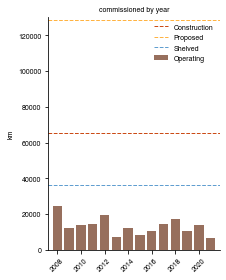

In [323]:
font_size = 7

ytop = 130000
ytop2 = 130000

fig = mp.figure(figsize=(3.25,4))

widths=[1]
spec = fig.add_gridspec(ncols=1, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2021.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax_hline_list = []
colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
for x,c,s in zip(xvals,colors,status):
    ax_hline_list.append(ax.axhline(y=pipes_indev[s],
             color=c, label=s, linewidth=1, linestyle='--'))


ax_h, ax_l = ax.get_legend_handles_labels()
#ax2_h, ax2_l = ax2.get_legend_handles_labels()
ax.legend(handles=ax_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-backto2008-hlines.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-backto2008-hlines.pdf', bbox_inches='tight', transparent=True)

## regional pipelines started in given year

In [324]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [325]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum

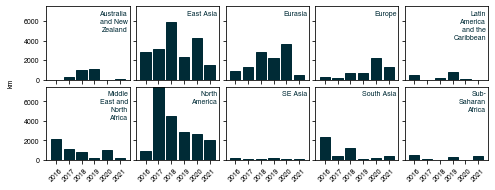

In [326]:
font_size = 7

fig = mp.figure(figsize=(6.75,2.75))#, constrained_layout=True)

start_year = 2016
end_year = 2021
ax_list = []

# plot the regional trends
for idx,region in enumerate(region_list):
    ax = fig.add_subplot(2,5,idx+1)
    
    ax_list.append(ax)
    ax.bar(numpy.arange(start_year,end_year+1), 
           regions_startyear_sums_df.loc[list(numpy.arange(start_year,end_year+1))][region].values,
           color=solar_base03, edgecolor=solar_base03)

    ax.set_xlim(2015.25, 2021.75)
    ax.set_ylim(0, 7500)#numpy.nanmean(regions_startyear_sums_df[region].values[:-1])*3)

    ax.text(x=0.98, y=0.95, s=('\n').join(textwrap.wrap(region, 10)), transform=ax.transAxes, c=solar_base03, 
            size=font_size, ha='right', va='top')
    
    ax.tick_params(labelsize=font_size)
    ax.tick_params('x', rotation=45)
    ax.set_xticks([2016,2017,2018,2019,2020,2021])
    
    if idx not in [0,5]:
        ax.set_yticklabels([])
    if idx<5:
        ax.set_xticklabels([])

#ax.set_title('gas pipelines (km) by start year', size=font_size)
fig.tight_layout(h_pad=0.25, w_pad=0.25)

ax1 = ax_list[0]
ax6 = ax_list[5]
ax1pos = ax2.get_position()
ax6pos = ax6.get_position()
fig.text(-0.005, ax6pos.y0+(ax1pos.y1-ax6pos.y0)/2,
         'km',
         size=font_size, ha='center', rotation=90)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_regional-km-by-start-year.png', 
           bbox_inches='tight', 
           transparent=True, 
           dpi=600)

## plot regional Proposed and Construction bar plots

## plot pie chart of regional values

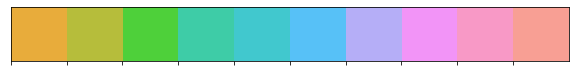

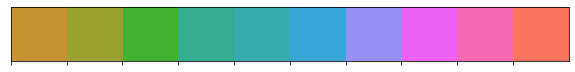

In [327]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

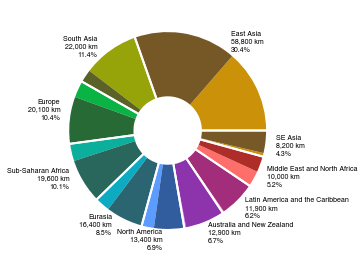

In [328]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_pie-graph-country-pipelines-km.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)


# Russia, India, China, USA, Aust, Brazil plots

In [331]:
pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating'])) & (pipes_df_orig['Fuel']=='Gas')]
pipes_started_sum_rus = pipes_started[pipes_started['Countries'].str.contains('Russia')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_chi = pipes_started[pipes_started['Countries'].str.contains('China')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_ind = pipes_started[pipes_started['Countries'].str.contains('India')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_usa = pipes_started[pipes_started['Countries'].str.contains('USA')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_aus = pipes_started[pipes_started['Countries'].str.contains('Australia')].groupby('StartYear1')['LengthMergedKm'].sum()
pipes_started_sum_bra = pipes_started[pipes_started['Countries'].str.contains('Brazil')].groupby('StartYear1')['LengthMergedKm'].sum()


In [332]:
start_year = 1950
end_year = 2021
window_length = end_year-start_year+1

### China

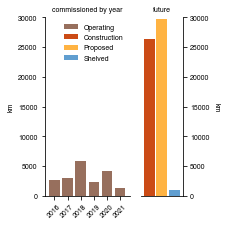

In [333]:
country = 'China'

font_size = 7
ytop = 30000
ytop2 = ytop

fig = mp.figure(figsize=(3.25,3.25))

widths=[6,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum_chi.index[-7:-1], pipes_started_sum_chi.values[-7:-1],
       color=tracker_operating, label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_xticks(range(2016,2022))
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.25, 2021.75)
ax.set_ylim(0, ytop)
#ax.text(s="{:,}".format(int(round(pipes_started_sum_chi.sum(), -2)))+" km total\noperating", x=0.1, y=0.5, 
#        ha='left', va='top', transform=ax.transAxes, fontsize=font_size, alpha=0.75)

ax.set_title('commissioned by year in '+country, size=font_size)

# ********************************************************************************

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc[country][s],
             width=0.9, color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

fig.tight_layout()#w_pad=0.05)#, hspace=None)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.pdf', bbox_inches='tight', transparent=True)

### India

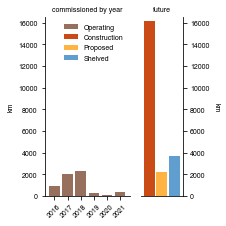

In [334]:
country = 'India'

font_size = 7
ytop = 16500
ytop2 = ytop

fig = mp.figure(figsize=(3.25,3.25))

widths=[6,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum_chi.index[-7:-1], pipes_started_sum_ind.values[-7:-1],
       color=tracker_operating, label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_xticks(range(2016,2022))
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.25, 2021.75)
ax.set_ylim(0, ytop)
#ax.text(s="{:,}".format(int(round(pipes_started_sum_ind.sum(), -2)))+" km total\noperating", x=0.1, y=0.5, 
#        ha='left', va='top', transform=ax.transAxes, fontsize=font_size, alpha=0.75)

ax.set_title('commissioned by year in '+country, size=font_size)

# ********************************************************************************

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc[country][s],
             width=0.9, color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

fig.tight_layout()#w_pad=0.05)#, hspace=None)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.pdf', bbox_inches='tight', transparent=True)

### USA

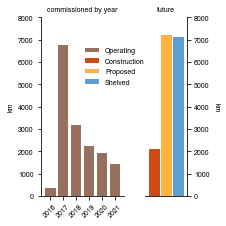

In [335]:
country = 'USA'

font_size = 7
ytop = 8000
ytop2 = ytop

fig = mp.figure(figsize=(3.25,3.25))

widths=[6,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum_chi.index[-7:-1], pipes_started_sum_usa.values[-7:-1],
       color=tracker_operating, label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_xticks(range(2016,2022))
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.25, 2021.75)
ax.set_ylim(0, ytop)
#ax.text(s="{:,}".format(int(round(pipes_started_sum_usa.sum(), -2)))+" km total\noperating", x=0.4, y=0.5, 
#        ha='left', va='top', transform=ax.transAxes, fontsize=font_size, alpha=0.75)

ax.set_title('commissioned by year in '+country, size=font_size)

# ********************************************************************************

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc[country][s],
             width=0.9, color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, loc=[0.5,0.6])#, bbox=ax.transAxes)

fig.tight_layout()#w_pad=0.05)#, hspace=None)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.pdf', bbox_inches='tight', transparent=True)

### Russia

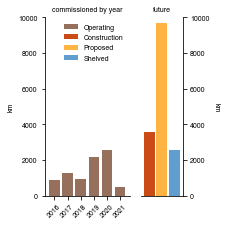

In [336]:
country = 'Russia'

font_size = 7
ytop = 10000
ytop2 = ytop

fig = mp.figure(figsize=(3.25,3.25))

widths=[6,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum_chi.index[-7:-1], pipes_started_sum_rus.values[-7:-1],
       color=tracker_operating, label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_xticks(range(2016,2022))
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.25, 2021.75)
ax.set_ylim(0, ytop)
#ax.text(s="{:,}".format(int(round(pipes_started_sum_rus.sum(), -2)))+" km total\noperating", x=0.1, y=0.5, 
#        ha='left', va='top', transform=ax.transAxes, fontsize=font_size, alpha=0.75)

ax.set_title('commissioned by year in '+country, size=font_size)

# ********************************************************************************

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc[country][s],
             width=0.9, color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

fig.tight_layout()#w_pad=0.05)#, hspace=None)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.pdf', bbox_inches='tight', transparent=True)

### Australia

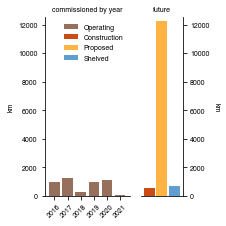

In [337]:
country = 'Australia'

font_size = 7
ytop = 12500
ytop2 = ytop

fig = mp.figure(figsize=(3.25,3.25))

widths=[6,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum_chi.index[-7:-1], pipes_started_sum_aus.values[-7:-1],
       color=tracker_operating, label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_xticks(range(2016,2022))
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.25, 2021.75)
ax.set_ylim(0, ytop)
#ax.text(s="{:,}".format(int(round(pipes_started_sum_aus.sum(), -2)))+" km total\noperating", x=0.1, y=0.5, 
#        ha='left', va='top', transform=ax.transAxes, fontsize=font_size, alpha=0.75)

ax.set_title('commissioned by year in '+country, size=font_size)

# ********************************************************************************

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc[country][s],
             width=0.9, color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

fig.tight_layout()#w_pad=0.05)#, hspace=None)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.pdf', bbox_inches='tight', transparent=True)

### Brazil

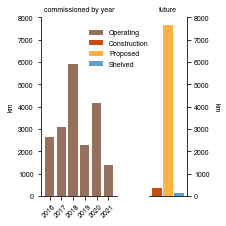

In [338]:
country = 'Brazil'

font_size = 7
ytop = 8000
ytop2 = ytop

fig = mp.figure(figsize=(3.25,3.25))

widths=[6,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)
ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum_chi.index[-7:-1], pipes_started_sum_chi.values[-7:-1],
       color=tracker_operating, label='Operating')
ax_h, ax_l = ax.get_legend_handles_labels()

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_xticks(range(2016,2022))
#ax.set_xlabel('start year', size=font_size)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2015.25, 2021.75)
ax.set_ylim(0, ytop)
#ax.text(s="{:,}".format(int(round(pipes_started_sum_bra.sum(), -3)))+" km total\noperating", x=0.6, y=0.7, 
#        ha='left', va='top', transform=ax.transAxes, fontsize=font_size, alpha=0.75)

ax.set_title('commissioned by year in '+country, size=font_size)

# ********************************************************************************

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

#colors = [solar_orange, solar_yellow, '0.75']
colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    ax2_list.append(ax2.bar(x, km_by_country_df.loc[country][s],
             width=0.9, color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, loc=[0.6,0.7])

fig.tight_layout()#w_pad=0.05)#, hspace=None)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_km-by-start-year-with-future-'+country+'.pdf', bbox_inches='tight', transparent=True)

# top 20 countries proposed+construction

In [339]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

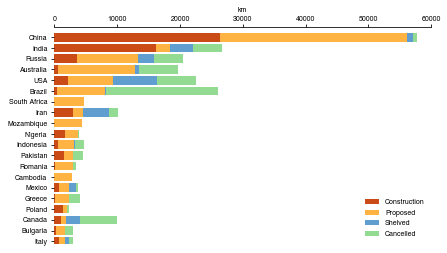

In [340]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/Gas-Pipelines-Report-2022_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/Gas-Pipelines-Report-2022_top-20-countries.png',
           bbox_inches='tight', 
           transparent=True,
           dpi=600)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_top-20-countries.pdf',
           bbox_inches='tight', 
           transparent=True)

In [341]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.051746405147723

# cost estimates (pipeline cost per km)

## looking for cost outliers

In [389]:
outliers_projectids = ['P2509','P0173','P1297','P0174','P3188','P2551','P1382','P0477']

#P1382 - grenada to trinidad an tobago - underwater, not really a formalized route yet, skipping
#P0477 - South Valley Pipeline (egypt) - just seems too high to make sense
#P3174 - Off-shore Gas Pipeline (all underwater, not quite representative?)

In [396]:
pipes_df_orig.loc[pipes_df_orig['ProjectID'].isin(outliers_projectids)]

PipelineNetworkContainer  \
826                             
827                             
1058                            
1590                            
1643                            
2307                            
2332                            
2799                            

                                         PipelineName  \
826                          Delfin Offshore Pipeline   
827               Denali Alaskan Natural Gas Pipeline   
1058                 South Valley Gas Pipeline (keep)   
1590                          Stratton Ridge Pipeline   
1643      Grenada to Trinidad and Tobago Gas Pipeline   
2307  Texas Eastern Transmission (TETCO) Gas Pipeline   
2332                             Leidy South Pipeline   
2799                        Columbia Gas Transmission   

                      SegmentName  \
826                                 
827                                 
1058                                
1590                                
1643                                
2307    Cameron Expansion Project   
2332                                
2799  East Lateral Xpress Project   

                                                   Wiki ProjectID Fuel  \
826       https://www.gem.wiki/Delfin_Offshore_Pipeline     P0173  Gas   
827   https://www.gem.wiki/Denali_Alaskan_Natural_Ga...     P0174  Gas   
1058     https://www.gem.wiki/South_Valley_Gas_Pipeline     P0477  Gas   
1590       https://www.gem.wiki/Stratton_Ridge_Pipeline     P1297  Gas   
1643  https://www.gem.wiki/Grenada_to_Trinidad_and_T...     P1382  Gas   
2307  https://www.gem.wiki/Texas_Eastern_Transmissio...     P2509  Gas   
2332          https://www.gem.wiki/Leidy_South_Pipeline     P2551  Gas   
2799     https://www.gem.wiki/Columbia_Gas_Transmission     P3188  Gas   

                         Countries Researcher LastUpdated        Status  \
826                            USA                             Proposed   
827                    USA, Canada                            Cancelled   
1058                         Egypt         BL  01/05/2022     Operating   
1590                           USA                            Operating   
1643  Grenada, Trinidad and Tobago         BL  01/05/2022      Proposed   
2307                           USA         JB  10/28/2021  Construction   
2332                           USA                         Construction   
2799                           USA         BL  08/25/2021      Proposed   

                                                 Parent ProposalYear  \
826   Fairwood Peninsula Energy Corporation; Golar L...                
827                                  BP; ConocoPhillips                
1058        Egyptian Natural Gas Holding Company (100%)                
1590                                           Enbridge                
1643  Global Petroleum Corporation; National Gas Com...                
2307                     Spectra Energy; ConocoPhillips                
2332                                 Williams Companies                
2799                                   TC Energy (100%)                

     ConstructionYear StartYear1 StartYear2 StartYear3 Delayed DelayType  \
826                         2022       2022                Yes  Presumed   
827                         2020                                           
1058                        2009                                           
1590                        2019                                           
1643                                                                       
2307                        2022                           Yes  Presumed   
2332                        2022                           Yes  Presumed   
2799                        2023                                           

     StartYearEarliest ShelvedYear CancelledYear StopYear  \
826               2022                                      
827               2020                                      

In [400]:
1-pipes_df_orig[pipes_df_orig['CostUSDPerKm'].isnull()].shape[0]/pipes_df_orig.shape[0]

0.12196620583717355

In [343]:
#pipes_cost_outliers_df = pipes_df[(pipes_df['Fuel']=='Gas') & (pipes_df['Countries'].str.contains('India'))]
pipes_cost_outliers_df = pipes_df_orig.copy()[(pipes_df_orig['Fuel']=='Gas')]
pipes_cost_outliers_df = pipes_cost_outliers_df[~pipes_cost_outliers_df.ProjectID.isin(outliers_projectids)]

In [344]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Gas') & 
                                    (country_ratios_df['CostMergedUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0)
                                   ]
country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [345]:
country_ratios_with_length_and_cost_df['CostMergedUSDPerKm'].drop_duplicates().mean()

3161566.478623595

### calculate regional costs

In [346]:
pipes_gas_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Region']==region]
    pipes_gas_costs_region_df.loc[region]['CostUSDPerKm'] = country_ratios_region_df['CostMergedUSDPerKm'].mean()
    pipes_gas_costs_region_df.loc[region]['NumberOfCosts'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    pipes_gas_costs_region_df.loc[region]['NumberOfLengths'] = list(set(country_ratios_region_df['ProjectID'])).__len__()
    

Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


### table for methodology with regional cost info

In [347]:
pipes_gas_costs_region_df

CostUSDPerKm  NumberOfCosts  NumberOfLengths
Australia and New Zealand             1271295             11               11
East Asia                             1693736             60               60
Eurasia                               3878476             18               18
Europe                                2980665             83               83
Latin America and the Caribbean       2798030             24               24
Middle East and North Africa          2558775             15               15
North America                         5130381            133              133
SE Asia                               2134476              9                9
South Asia                            1147718             19               19
Sub-Saharan Africa                    3860864              6                6

### calculate country-level costs

In [348]:
#country_list_for_costs = sorted(list(set(country_ratios_with_length_and_cost_df['Country'])))
pipes_gas_costs_country_df = pandas.DataFrame(0, index=country_list, columns=['CostUSDPerKm','NumberOfCosts','NumberOfLengths'])

for country in country_list:#_for_costs:
    #print(country)
    country_ratios_country_df = country_ratios_with_length_and_cost_df[country_ratios_with_length_and_cost_df['Country']==country]
    pipes_gas_costs_country_df.loc[country,'CostUSDPerKm'] = country_ratios_country_df['CostMergedUSDPerKm'].mean()
    pipes_gas_costs_country_df.loc[country,'NumberOfCosts'] = list(set(country_ratios_country_df['ProjectID'])).__len__()
    pipes_gas_costs_country_df.loc[country,'NumberOfLengths'] = list(set(country_ratios_country_df['ProjectID'])).__len__()

## table for regional totals

In [349]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

Proposed  Construction  \
East Asia                        32,420.1      26,347.7   
South Asia                        4,091.0      17,859.7   
Europe                           14,832.9       5,290.6   
Sub-Saharan Africa               14,048.0       5,517.9   
Eurasia                          11,689.3       4,719.0   
North America                     9,526.9       3,897.7   
Australia and New Zealand        12,369.5         580.0   
Latin America and the Caribbean  11,364.0         541.0   
Middle East and North Africa      5,028.8       5,014.2   
SE Asia                           7,106.4       1,121.0   
Total                           122,477.1      70,888.8   

                                 Proposed+Construction  Shelved  Cancelled  \
East Asia                                     58,767.8  1,044.0    1,044.1   
South Asia                                    21,950.7  6,017.7    6,143.8   
Europe                                        20,123.5  1,247.9   15,805.3   
Sub-Saharan Africa                            19,565.9  1,633.2      288.2   
Eurasia                                       16,408.3  2,556.8    6,644.1   
North America                                 13,424.6 10,445.8   12,432.1   
Australia and New Zealand                     12,949.5    682.0    6,208.5   
Latin America and the Caribbean               11,905.0  3,453.0   22,161.3   
Middle East and North Africa                  10,043.1  7,178.7    3,704.5   
SE Asia                                        8,227.4  2,630.4    3,180.8   
Total                                        193,365.9 36,889.5   77,612.8   

                                 Operating    Idle  Mothballed  Retired  
East Asia                         92,429.1     0.0         0.0     41.0  
South Asia                        20,585.8     0.0         0.0     35.0  
Europe                           116,899.3     0.0         0.0  1,080.0  
Sub-Saharan Africa                13,550.9     0.0         0.0      0.0  
Eurasia                          140,257.5     0.0       193.0  2,551.9  
North America                    418,631.0   516.0         0.0      0.0  
Australia and New Zealand         30,993.0     0.0         0.0      0.0  
Latin America and the Caribbean   43,412.5     0.0       224.0      0.0  
Middle East and North Africa      33,369.8 1,200.0         0.0     39.3  
SE Asia                           15,839.9     0.0         0.0      0.0  
Total                            925,968.8 1,716.0       417.0  3,747.1

## table for km by country

In [350]:
# saves all countries to an Excel file for reference
if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/GGIT-km-by-country.xlsx')

## table for stranded asset calculations

In [351]:
pandas.options.display.float_format = '{:,.1f}'.format
#km_by_region_df.sort_index(inplace=True)
#indices_without_total = list(km_by_region_df.index)
#if 'Total' in indices_without_total:
#    indices_without_total.remove('Total')

capex_estimates_df = km_by_region_df.loc[region_list].multiply(pipes_gas_costs_region_df['CostUSDPerKm'].values, axis=0) / 1e9

capex_estimates_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

total = capex_estimates_df.sum(axis=0)
total.name='Total'
capex_estimates_df = capex_estimates_df.append(total)

capex_estimates_df

Proposed  Construction  \
East Asia                            54.9          44.6   
Sub-Saharan Africa                   54.2          21.3   
North America                        48.9          20.0   
Eurasia                              45.3          18.3   
Europe                               44.2          15.8   
Latin America and the Caribbean      31.8           1.5   
Middle East and North Africa         12.9          12.8   
South Asia                            4.7          20.5   
SE Asia                              15.2           2.4   
Australia and New Zealand            15.7           0.7   
Total                               327.8         158.0   

                                 Proposed+Construction  Shelved  Cancelled  \
East Asia                                         99.5      1.8        1.8   
Sub-Saharan Africa                                75.5      6.3        1.1   
North America                                     68.9     53.6       63.8   
Eurasia                                           63.6      9.9       25.8   
Europe                                            60.0      3.7       47.1   
Latin America and the Caribbean                   33.3      9.7       62.0   
Middle East and North Africa                      25.7     18.4        9.5   
South Asia                                        25.2      6.9        7.1   
SE Asia                                           17.6      5.6        6.8   
Australia and New Zealand                         16.5      0.9        7.9   
Total                                            485.8    116.7      232.8   

                                 Operating  Idle  Mothballed  Retired  
East Asia                            156.6   0.0         0.0      0.1  
Sub-Saharan Africa                    52.3   0.0         0.0      0.0  
North America                      2,147.7   2.6         0.0      0.0  
Eurasia                              544.0   0.0         0.7      9.9  
Europe                               348.4   0.0         0.0      3.2  
Latin America and the Caribbean      121.5   0.0         0.6      0.0  
Middle East and North Africa          85.4   3.1         0.0      0.1  
South Asia                            23.6   0.0         0.0      0.0  
SE Asia                               33.8   0.0         0.0      0.0  
Australia and New Zealand             39.4   0.0         0.0      0.0  
Total                              3,552.7   5.7         1.4     13.3

## print out country-level stranded assets for report discussion

In [354]:
pandas.options.display.float_format = '{:,.1f}'.format

these_countries = ['China','India','USA','Russia','Australia','Brazil']

for cty in these_countries:
    print(cty)
    print(km_by_country_df.loc[cty]['Proposed'], ' km proposed')
    print(km_by_country_df.loc[cty]['Construction'], ' km in construction')
    print(km_by_country_df.loc[cty]['Proposed+Construction'], ' total km in development')
    print(pipes_gas_costs_country_df.loc[cty])
    print(pipes_gas_costs_country_df.loc[cty]['CostUSDPerKm']*km_by_country_df.loc[cty]/1e9)
    print()

China
29794.16  km proposed
26325.9  km in construction
56120.06  total km in development
CostUSDPerKm      1,588,286.4
NumberOfCosts            58.0
NumberOfLengths          58.0
Name: China, dtype: float64
Proposed                 47.3
Construction             41.8
Proposed+Construction    89.1
Shelved                   1.6
Cancelled                 0.9
Operating               138.8
Idle                      0.0
Mothballed                0.0
Retired                   0.0
Name: China, dtype: float64

India
2229.2799999999997  km proposed
16160.21  km in construction
18389.489999999998  total km in development
CostUSDPerKm      799,179.6
NumberOfCosts          11.0
NumberOfLengths        11.0
Name: India, dtype: float64
Proposed                 1.8
Construction            12.9
Proposed+Construction   14.7
Shelved                  2.9
Cancelled                3.7
Operating               13.3
Idle                     0.0
Mothballed               0.0
Retired                  0.0
Name: Ind

## country-level table for stranded asset calculations

In [355]:
pandas.options.display.float_format = '{:,.1f}'.format
#km_by_region_df.sort_index(inplace=True)
#indices_without_total = list(km_by_region_df.index)
#if 'Total' in indices_without_total:
#    indices_without_total.remove('Total')

capex_estimates_country_df = km_by_region_df.loc[region_list].multiply(pipes_gas_costs_region_df['CostUSDPerKm'].values, axis=0) / 1e9

if 'Total' in capex_estimates_df.index:
    capex_estimates_df.drop(index='Total', inplace=True)   
    total = capex_estimates_df.sum(axis=0)
    total.name='Total'
    capex_estimates_df = capex_estimates_df.append(total)

else:
    total = capex_estimates_df.sum(axis=0)
    total.name='Total'
    capex_estimates_df = capex_estimates_df.append(total)

capex_estimates_df

Proposed  Construction  \
East Asia                            54.9          44.6   
Sub-Saharan Africa                   54.2          21.3   
North America                        48.9          20.0   
Eurasia                              45.3          18.3   
Europe                               44.2          15.8   
Latin America and the Caribbean      31.8           1.5   
Middle East and North Africa         12.9          12.8   
South Asia                            4.7          20.5   
SE Asia                              15.2           2.4   
Australia and New Zealand            15.7           0.7   
Total                               327.8         158.0   

                                 Proposed+Construction  Shelved  Cancelled  \
East Asia                                         99.5      1.8        1.8   
Sub-Saharan Africa                                75.5      6.3        1.1   
North America                                     68.9     53.6       63.8   
Eurasia                                           63.6      9.9       25.8   
Europe                                            60.0      3.7       47.1   
Latin America and the Caribbean                   33.3      9.7       62.0   
Middle East and North Africa                      25.7     18.4        9.5   
South Asia                                        25.2      6.9        7.1   
SE Asia                                           17.6      5.6        6.8   
Australia and New Zealand                         16.5      0.9        7.9   
Total                                            485.8    116.7      232.8   

                                 Operating  Idle  Mothballed  Retired  
East Asia                            156.6   0.0         0.0      0.1  
Sub-Saharan Africa                    52.3   0.0         0.0      0.0  
North America                      2,147.7   2.6         0.0      0.0  
Eurasia                              544.0   0.0         0.7      9.9  
Europe                               348.4   0.0         0.0      3.2  
Latin America and the Caribbean      121.5   0.0         0.6      0.0  
Middle East and North Africa          85.4   3.1         0.0      0.1  
South Asia                            23.6   0.0         0.0      0.0  
SE Asia                               33.8   0.0         0.0      0.0  
Australia and New Zealand             39.4   0.0         0.0      0.0  
Total                              3,552.7   5.7         1.4     13.3

## pie chart for stranded assets

In [356]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)[1:]

Proposed  Construction  \
East Asia                            54.9          44.6   
Sub-Saharan Africa                   54.2          21.3   
North America                        48.9          20.0   
Eurasia                              45.3          18.3   
Europe                               44.2          15.8   
Latin America and the Caribbean      31.8           1.5   
Middle East and North Africa         12.9          12.8   
South Asia                            4.7          20.5   
SE Asia                              15.2           2.4   
Australia and New Zealand            15.7           0.7   

                                 Proposed+Construction  Shelved  Cancelled  \
East Asia                                         99.5      1.8        1.8   
Sub-Saharan Africa                                75.5      6.3        1.1   
North America                                     68.9     53.6       63.8   
Eurasia                                           63.6      9.9       25.8   
Europe                                            60.0      3.7       47.1   
Latin America and the Caribbean                   33.3      9.7       62.0   
Middle East and North Africa                      25.7     18.4        9.5   
South Asia                                        25.2      6.9        7.1   
SE Asia                                           17.6      5.6        6.8   
Australia and New Zealand                         16.5      0.9        7.9   

                                 Operating  Idle  Mothballed  Retired  
East Asia                            156.6   0.0         0.0      0.1  
Sub-Saharan Africa                    52.3   0.0         0.0      0.0  
North America                      2,147.7   2.6         0.0      0.0  
Eurasia                              544.0   0.0         0.7      9.9  
Europe                               348.4   0.0         0.0      3.2  
Latin America and the Caribbean      121.5   0.0         0.6      0.0  
Middle East and North Africa          85.4   3.1         0.0      0.1  
South Asia                            23.6   0.0         0.0      0.0  
SE Asia                               33.8   0.0         0.0      0.0  
Australia and New Zealand             39.4   0.0         0.0      0.0

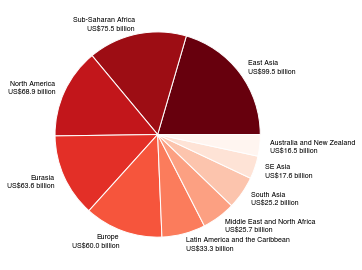

In [357]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)
cmap = mp.get_cmap('Reds')

pie_vals = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]
pie_labels = capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]
pie_labels_dollars = capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'\nUS${x:.1f} billion')[1:]

pie_labels = [i+j for i,j in zip(pie_labels, pie_labels_dollars)]

ax.pie(pie_vals, 
       labels=pie_labels,
       colors=cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1'),
       textprops={'fontsize':font_size})

ax.tick_params(labelsize=font_size)

fig.tight_layout()

#mp.savefig('saved-figures/Gas-Pipelines-Report-2022_pie-graph.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_pie-graph.png', 
           bbox_inches='tight', 
           transparent=True,
           dpi=600)

mp.savefig('saved-figures/Gas-Pipelines-Report-2022_pie-graph.pdf', 
           bbox_inches='tight', 
           transparent=True)


In [358]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'].apply(lambda x: f'US${x:.2f} billion')[1:]

East Asia                          US$99.54 billion
Sub-Saharan Africa                 US$75.54 billion
North America                      US$68.87 billion
Eurasia                            US$63.64 billion
Europe                             US$59.98 billion
Latin America and the Caribbean    US$33.31 billion
Middle East and North Africa       US$25.70 billion
South Asia                         US$25.19 billion
SE Asia                            US$17.56 billion
Australia and New Zealand          US$16.46 billion
Name: Proposed+Construction, dtype: object

In [359]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False)['Proposed+Construction'][1:]

East Asia                         99.5
Sub-Saharan Africa                75.5
North America                     68.9
Eurasia                           63.6
Europe                            60.0
Latin America and the Caribbean   33.3
Middle East and North Africa      25.7
South Asia                        25.2
SE Asia                           17.6
Australia and New Zealand         16.5
Name: Proposed+Construction, dtype: float64

In [360]:
capex_estimates_df.sort_values('Proposed+Construction', ascending=False).index[1:]

Index(['East Asia', 'Sub-Saharan Africa', 'North America', 'Eurasia', 'Europe',
       'Latin America and the Caribbean', 'Middle East and North Africa',
       'South Asia', 'SE Asia', 'Australia and New Zealand'],
      dtype='object')

### amount already being constructed

In [361]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.3666044857648383

In [362]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

0.32517736715780604

# numbers for report

## km of pipeline with 2022, 2023 start years

In [363]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2022],
      pipes_indev_startyear.loc['Construction',2023])

print(pipes_indev_startyear.loc['Proposed',2022],
      pipes_indev_startyear.loc['Proposed',2023])

36824.76000000001 10453.9
7785.45 12241.850000000002


## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations, so we've used the regional calculation totals instead (193,365.9)

In [365]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

194025.74000000005

In [366]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [367]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Gas')]['MergedKmByCountry'].sum()

193365.90999999997

### China's percent of total

In [368]:
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df['Proposed+Construction'].sum(axis=0)

0.14511363455947326

In [369]:
km_by_country_df[:6]['Proposed+Construction'].sum(axis=0)/km_by_country_df[:-1]['Proposed+Construction'].sum(axis=0)

0.6096732355770466

In [370]:
km_by_country_df[:20]['Proposed+Construction'].sum(axis=0)/km_by_country_df[:-1]['Proposed+Construction'].sum(axis=0)

0.8216481902109839

## number of delayed km from 2021 to 2022

for report figures

In [372]:
pipes_delays_df = pipes_df_orig.copy()
pipes_delays_df = pipes_delays_df[(pipes_delays_df['Fuel']=='Gas') &
                                  (pipes_delays_df['Delayed']=='Yes') &
                                   (pipes_delays_df['StartYearEarliest']==2022)]

pipes_delays_df.groupby('Status')['LengthMergedKm'].sum()

Status
Construction   24,989.9
Proposed        3,904.8
Name: LengthMergedKm, dtype: object

In [373]:
# number of delays that quality as "presumed" is smaller
pipes_delays_df = pipes_df_orig.copy()
pipes_delays_df = pipes_delays_df[(pipes_delays_df['Fuel']=='Gas') &
                                  (pipes_delays_df['Delayed']=='Yes') &
                                   (pipes_delays_df['StartYearEarliest']==2022) &
                                   (pipes_delays_df['DelayType']=='Presumed')]

pipes_delays_df.groupby('Status')['LengthMergedKm'].sum()

Status
Construction   22,206.9
Proposed        3,817.8
Name: LengthMergedKm, dtype: object

## num of projects in database with nonzero length

In [374]:
no_route_types = [#'Unavailable',
                  'Capacity expansion only',
                  'Bidirectionality upgrade only']#,
                  #'Short route (< 100 km)',
                  #'N/A']

### isolate anything with a nonzero length in database

In [375]:
numprojects = pipes_df_orig.copy()
numprojects = numprojects[~numprojects['Route'].isin(no_route_types)]
numprojects = numprojects[(numprojects['Fuel']=='Gas') &
                          (numprojects['Status'].isin(['Proposed','Construction']))]

In [376]:
print(numprojects.shape)
print(numprojects['LengthMergedKm'].median())

(511, 75)
160.0


In [377]:
numprojects.groupby(['StartYearEarliest','Status'])['LengthMergedKm'].sum()

StartYearEarliest  Status      
2019               Proposed          450.0
2022               Construction   36,824.8
                   Proposed        7,785.4
2023               Construction   10,453.9
                   Proposed       12,241.9
2024               Construction    3,326.0
                   Proposed        3,698.2
2025               Construction      759.0
                   Proposed       11,781.9
2026               Proposed          949.0
2027               Proposed        2,270.0
2028               Proposed        5,006.0
2029               Proposed          962.0
2030               Proposed            8.0
2034               Proposed          255.0
2035               Proposed          110.0
2046               Proposed        5,660.0
Name: LengthMergedKm, dtype: object

#### check that it's the right thing

In [378]:
numprojects['LengthMergedKm'].sum()

194025.74000000005

### calc capacity expansion only

In [379]:
numprojects_capexp = pipes_df_orig.copy()
numprojects_capexp = numprojects_capexp[numprojects_capexp['Route'].isin(no_route_types)]
numprojects_capexp = numprojects_capexp[(numprojects_capexp['Fuel']=='Gas') &
                          (numprojects_capexp['Status'].isin(['Proposed','Construction']))]

In [380]:
numprojects_capexp.shape

(50, 75)

(-100.0, 2000.0)

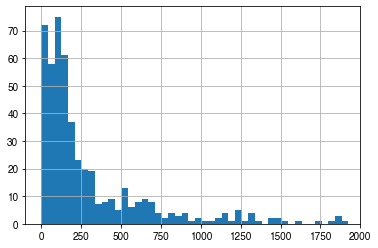

In [381]:
ax = numprojects['LengthMergedKm'].hist(bins=200)#mean()
ax.set_xlim(-100,2000)

## global km of pipeline by start year

In [382]:
pipes_started_sum

StartYearEarliest
1983   1,117.0
1989     340.0
1995     600.0
1999      80.0
2004   2,455.0
2006     677.0
2011     196.0
2014     100.0
2015     533.0
2016     500.0
2017     128.0
2019     245.0
2021     412.0
Name: LengthMergedKm, dtype: object

In [383]:
#pipes_indev_startyear = pipes_df_orig.copy()
#pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
#                                              (pipes_indev_startyear['Fuel']=='Gas')]
#pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'])['LengthMergedKm'].sum()
pipes_indev_startyear_df = pipes_indev_startyear.to_frame()

In [384]:
pipes_2023_2030_subset_df = pipes_indev_startyear_df.query('StartYearEarliest<2031 and StartYearEarliest>2022')
#pipes_2023_2030_subset_df.query('Status==Construction or Status==Proposed')
pipes_2023_2030_subset_df.groupby('Status').sum().loc[['Construction','Proposed']].sum()


LengthMergedKm   51,455.9
dtype: float64

### sum of anything 2023 onward that is in construction or proposed

In [385]:
#pipes_indev_startyear_df.query("Status=='Construction' or Status=='Proposed'")
pipes_indev_startyear_df.query("(Status=='Construction' or Status=='Proposed') and StartYearEarliest>2022").sum()

LengthMergedKm   57,480.9
dtype: object